In [1]:
import os, os.path
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
from torchvision import datasets, models, transforms

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

Module: Load_data

In [2]:
def load_data(hieroglyph_directory_path, batch_size=20, num_workers=0):
    train_dir = os.path.join(hieroglyph_directory_path, 'train/')
    test_dir = os.path.join(hieroglyph_directory_path, 'test/')

    classes = []

    for filename in os.listdir(train_dir):
        if filename == '.DS_Store':
            pass
        else:
            classes.append(filename)

    classes.sort()

    # print("Our classes:", classes)
    # print(len(classes))

    data_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.RandomApply([transforms.RandomHorizontalFlip()]),
                                         transforms.RandomRotation(degrees=(-10, 10)),
                                         transforms.RandomAffine(degrees=0, translate=(.1, .1)),
                                         transforms.RandomApply([transforms.ColorJitter(brightness=(1, 1.2),
                                                                                        contrast=(1, 1.5),
                                                                                        saturation=(1, 1.5),
                                                                                        hue=(0, 0.5))]),
                                         transforms.RandomErasing(p=0.5, scale=(0.05, 0.05), ratio=(0.3, 3.3), value=0,
                                                                  inplace=False),
                                         transforms.Normalize((0.5,), (0.5,))])

    train_data = datasets.ImageFolder(train_dir, transform=data_transform)
    test_data = datasets.ImageFolder(test_dir, transform=data_transform)

    # print('Num training images: ', len(train_data))
    # print('Num test images: ', len(test_data))

    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               num_workers=num_workers, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                              num_workers=num_workers, shuffle=True)

    return train_loader, test_loader, classes

Module: Train_model

In [3]:
def train_model(train_loader, optimizer, resnet50, criterion, my_lr_scheduler, n_epochs):
    # track training loss over time
    losses = []
    
    for epoch in range(1, n_epochs + 1):

        # keep track of training and validation loss
        train_loss = 0.0

        # model by default is set to train
        for batch_i, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = resnet50(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()

            my_lr_scheduler.step()

            if batch_i % 20 == 19:  # print training loss every specified number of mini-batches
                print('Epoch %d, Batch %d loss: %.16f' %
                    (epoch, batch_i + 1, train_loss / 20))
                losses.append(train_loss / 20)
                train_loss = 0.0
        
        

    return resnet50, losses

Module: Test_model

In [4]:
def test_model(classes, resnet50, test_loader, criterion):
    # track test loss
    test_loss = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))

    resnet50.eval()  # eval mode

    labels = []
    predictions = []
    # iterate over test data
    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = resnet50(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update  test loss
        test_loss += loss.item() * data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(len(target.data)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        
        # Will be used for calculating Recall, Precision, and F1-score
        labels.extend(target.data.view_as(pred).tolist())
        predictions.extend(pred.tolist())


    # calculate avg test loss
    test_loss = test_loss / len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    return test_loss, class_correct, class_total, labels, predictions

Check whether CUDA is available (Change runtime type if not)

In [5]:
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


Load Hieroglyph Data

In [6]:
# Connecting and Mounting to the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
data_dir = '/content/drive/MyDrive/EgyptianHieroglyphDataset_Original/'

In [8]:
hieroglyph_for_train = []
file_count_list = []

for name in os.listdir('/content/drive/MyDrive/EgyptianHieroglyphDataset_Original/train/'):
  path, dirs, files = next(os.walk("/content/drive/MyDrive/EgyptianHieroglyphDataset_Original/train/"+name))
  file_count = len(files)
  print(name, file_count)
  file_count_list.append(file_count)
  hieroglyph_for_train.append(name)

hieroglyph_dict = dict(zip(hieroglyph_for_train, file_count_list))

D4 29
D2 19
D46 40
D36 47
D21 146
D58 28
E34 97
E23 8
F31 6
G1 28
F35 2
G17 156
G43 157
I10 32
I9 116
M23 30
M17 291
O1 16
O34 15
N35 358
Q3 61
O49 10
Q1 13
O4 11
S34 8
R4 2
R8 53
S29 212
V13 63
V28 28
U7 3
V30 6
W11 4
W24 31
V31 106
Y5 6
X8 4
Z1 39
X1 185
Y1 1


Number of images for each hieroglyph 

<BarContainer object of 40 artists>

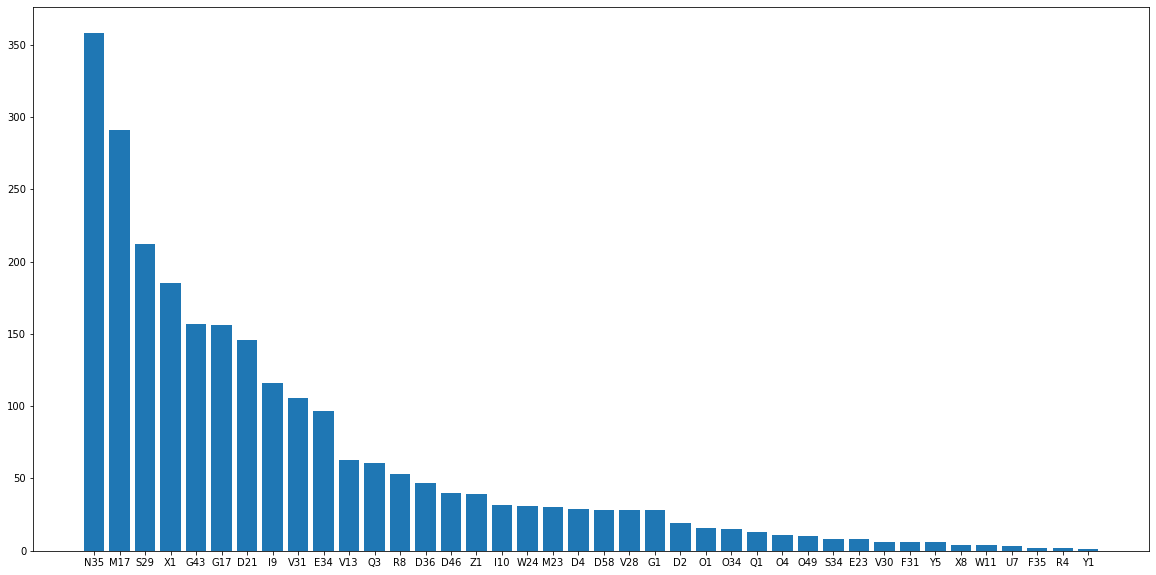

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({"Hieroglyph":hieroglyph_for_train, "Count":file_count_list})

df_sorted= df.sort_values('Count',ascending=False)

plt.figure(figsize=(20,10))
# make bar plot with matplotlib
plt.bar('Hieroglyph', 'Count',data=df_sorted)

In [10]:
# Number of images processed in a single training
batch_size = 20
num_workers = 0

# The load_data function is from hieroglyph_data_preparation python file
train_loader, test_loader, classes = load_data(data_dir)

ResNet Model

In [11]:
# Whether to extract features with the model
feature_extract = False
# Other selections
loss_function = "cross-entropy"
model_selection = "resnet-50"
optim_selection = "Adam"

# False if you want scratch model, True if you want pretrained model
whether_to_pretrain = False

# Load the model
if model_selection == "resnet-50":
    resnet50 = models.resnet50(pretrained=whether_to_pretrain)

# Number of features in the last layer of resnet
n_inputs = resnet50.fc.in_features

# Add last linear layer (n_inputs -> 40 hieroglyph classes)
# New layers automatically have requires_grad = True
last_layer = nn.Sequential(
                nn.Linear(n_inputs, len(classes)))

resnet50.fc = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    resnet50.cuda()

# Specify loss function (categorical cross-entropy)
if loss_function == "cross-entropy":
    criterion = nn.CrossEntropyLoss()

# Specify optimizer (Adam) and learning rate = 0.001
if optim_selection == "Adam":
    optimizer = optim.Adam(resnet50.parameters(), lr=0.001)

# Exponential Decay to strengthen learning
decayRate = 0.999
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

Training the model

In [12]:
# number of epochs to train the model
n_epochs = 50

# The train_model function is from model_training python file
resnet50, train_losses = train_model(train_loader, optimizer, resnet50, criterion, my_lr_scheduler, n_epochs)

Epoch 1, Batch 20 loss: 4.6956895232200626
Epoch 1, Batch 40 loss: 4.0507528781890869
Epoch 1, Batch 60 loss: 3.2342140913009643
Epoch 1, Batch 80 loss: 3.1120088219642641
Epoch 1, Batch 100 loss: 2.8531004190444946
Epoch 1, Batch 120 loss: 2.5038884699344637
Epoch 2, Batch 20 loss: 2.4888750314712524
Epoch 2, Batch 40 loss: 2.3710653662681578
Epoch 2, Batch 60 loss: 2.0419309735298157
Epoch 2, Batch 80 loss: 1.8860107541084290
Epoch 2, Batch 100 loss: 1.8485005021095275
Epoch 2, Batch 120 loss: 1.8487040281295777
Epoch 3, Batch 20 loss: 1.7774251818656921
Epoch 3, Batch 40 loss: 1.5283051729202271
Epoch 3, Batch 60 loss: 1.4139348179101945
Epoch 3, Batch 80 loss: 1.5722999870777130
Epoch 3, Batch 100 loss: 1.6894179463386536
Epoch 3, Batch 120 loss: 1.2990058600902556
Epoch 4, Batch 20 loss: 1.4063344180583954
Epoch 4, Batch 40 loss: 1.3406311780214311
Epoch 4, Batch 60 loss: 1.1933122172951698
Epoch 4, Batch 80 loss: 1.1121811211109160
Epoch 4, Batch 100 loss: 0.9535857141017914
Epoc

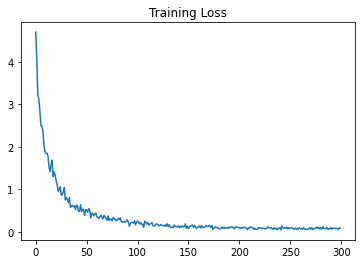

In [13]:
plt.plot(train_losses)
plt.title("Training Loss")
plt.show()

Testing the model

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [15]:
# The test_model function is from model_testing python file
test_loss, class_correct, class_total, labels, predictions = test_model(classes, resnet50, test_loader, criterion)

# Test accuracy for each hieroglyph
for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

# Total Test accuracy
print("\nAccuracy: {:.3%}".format(accuracy_score(labels, predictions)))
print("\nPrecision: {:.3%}".format(precision_score(labels, predictions, average = 'weighted')))
print("\nRecall: {:.3%}".format(recall_score(labels, predictions, average = 'weighted')))
print("\nF1-score: {:.3%}".format(f1_score(labels, predictions, average = 'weighted')))

Test Loss: 0.137239

Test Accuracy of    D2: 100% ( 5/ 5)
Test Accuracy of   D21: 89% (33/37)
Test Accuracy of   D36: 100% (12/12)
Test Accuracy of    D4: 87% ( 7/ 8)
Test Accuracy of   D46: 60% ( 6/10)
Test Accuracy of   D58: 100% ( 8/ 8)
Test Accuracy of   E23: 50% ( 1/ 2)
Test Accuracy of   E34: 96% (24/25)
Test Accuracy of   F31: 100% ( 2/ 2)
Test Accuracy of   F35: 100% ( 1/ 1)
Test Accuracy of    G1: 85% ( 6/ 7)
Test Accuracy of   G17: 94% (37/39)
Test Accuracy of   G43: 97% (39/40)
Test Accuracy of   I10: 100% ( 9/ 9)
Test Accuracy of    I9: 96% (29/30)
Test Accuracy of   M17: 98% (72/73)
Test Accuracy of   M23: 100% ( 8/ 8)
Test Accuracy of   N35: 100% (90/90)
Test Accuracy of    O1: 100% ( 4/ 4)
Test Accuracy of   O34: 100% ( 4/ 4)
Test Accuracy of    O4: 100% ( 3/ 3)
Test Accuracy of   O49: 100% ( 3/ 3)
Test Accuracy of    Q1: 75% ( 3/ 4)
Test Accuracy of    Q3: 93% (15/16)
Test Accuracy of    R4:  0% ( 0/ 1)
Test Accuracy of    R8: 92% (13/14)
Test Accuracy of   S29: 100% (5

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
